In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


In [2]:
# Load the data
df = pd.read_csv('../data/train_cleaned.csv')
df.head()


,id,target,airline,std_day,sta_day,std_month,sta_month,std_time_dec,iso_country_dep,type_dep,iso_country_arr,type_arr,is_same_country
0,train_id_0,260.0,TU,Sunday,Sunday,January,January,10.5,MA,large_airport,TN,large_airport,False
1,train_id_1,20.0,TU,Wednesday,Wednesday,January,January,15.1,IT,large_airport,TN,large_airport,False
2,train_id_2,0.0,TU,Saturday,Saturday,January,January,4.2,TN,large_airport,TR,large_airport,False
3,train_id_3,0.0,TU,Sunday,Sunday,January,January,14.2,TN,medium_airport,FR,medium_airport,False
4,train_id_4,22.0,TU,Sunday,Sunday,January,January,14.5,TN,large_airport,DZ,large_airport,False


### feature target separation

In [3]:
# Split the data into features and target label
X = df.drop(['target', 'id'], axis=1)
y = df['target']

### log transformation of target

In [4]:
#Log transform the target
y = np.log1p(y)

<Axes: >

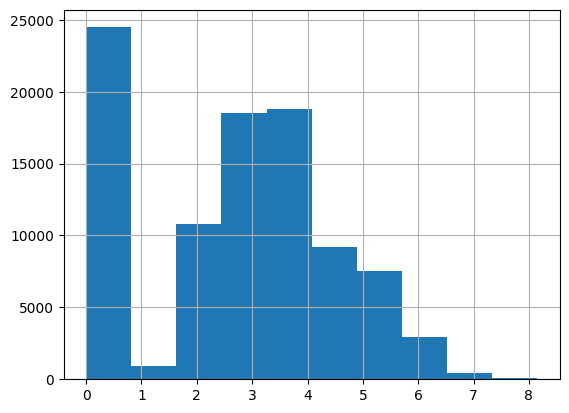

In [5]:
y.hist()

In [6]:
# #one-hot encode features
# X = pd.get_dummies(X)

### train test split

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### safe data for catboost model (can handle categorical data)

In [8]:
# save X_train, X_test, y_train, y_test in csv files without dummy encoding
X_train.to_csv('../data/X_train_wodum.csv', index=False)
X_test.to_csv('../data/X_test_wodum.csv', index=False)
y_train.to_csv('../data/y_train_wodum.csv', index=False)
y_test.to_csv('../data/y_test_wodum.csv', index=False)

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74943 entries, 65956 to 15795
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          74943 non-null  object 
 1   std_day          74943 non-null  object 
 2   sta_day          74943 non-null  object 
 3   std_month        74943 non-null  object 
 4   sta_month        74943 non-null  object 
 5   std_time_dec     74943 non-null  float64
 6   iso_country_dep  74943 non-null  object 
 7   type_dep         74943 non-null  object 
 8   iso_country_arr  74943 non-null  object 
 9   type_arr         74943 non-null  object 
 10  is_same_country  74943 non-null  bool   
dtypes: bool(1), float64(1), object(9)
memory usage: 6.4+ MB


### use scaler on time

In [10]:
# scaler = StandardScaler()

# # Fit and transform the specified columns
# X_train[['sta_time_dec', 'std_time_dec']] = scaler.fit_transform(X_train[['sta_time_dec', 'std_time_dec']])
# X_test[['sta_time_dec', 'std_time_dec']] = scaler.transform(X_test[['sta_time_dec', 'std_time_dec']])

### make dummie variables (after train test split, as data needed for catboost)

In [11]:
#make dummie variables

# Define categorical, boolean, and numerical features
categorical_features = [
    'airline', 'std_day', 'sta_day', 'std_month', 'sta_month', 'iso_country_dep', 'iso_country_arr', 'type_dep', 'type_arr'
]
boolean_features = ['is_same_country']
numerical_features = ['std_time_dec']  # Add other numerical features here

# Initialize transformers
one_hot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', one_hot, categorical_features),
        ('passthrough', 'passthrough', boolean_features + numerical_features)  
    ])

# Fit and transform data
preprocessor.fit(X_train)
X_train_encoded = preprocessor.transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Get the feature names from the preprocessor
feature_names = preprocessor.get_feature_names_out()

# Convert X_train_encoded and X_test_encoded to DataFrames
X_train = pd.DataFrame(X_train_encoded, columns=feature_names)
X_test = pd.DataFrame(X_test_encoded, columns=feature_names)

In [12]:
X_train.head()

,one_hot__airline_5K,one_hot__airline_5M,one_hot__airline_6P,one_hot__airline_BJ,one_hot__airline_D4,one_hot__airline_GJ,one_hot__airline_GW,one_hot__airline_OL,one_hot__airline_PS,one_hot__airline_QS,...,one_hot__iso_country_arr_TR,one_hot__iso_country_arr_UA,one_hot__type_dep_large_airport,one_hot__type_dep_medium_airport,one_hot__type_dep_small_airport,one_hot__type_arr_large_airport,one_hot__type_arr_medium_airport,one_hot__type_arr_small_airport,passthrough__is_same_country,passthrough__std_time_dec
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,False,11.4
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,False,18.2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,False,13.8
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,False,9.3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,False,10.0


### save the data

In [13]:
# save X_train, X_test, y_train, y_test in csv files
X_train.to_csv('../data/X_train.csv', index=False)
X_test.to_csv('../data/X_test.csv', index=False)
y_train.to_csv('../data/y_train.csv', index=False)
y_test.to_csv('../data/y_test.csv', index=False)

## maybe scaling of features, as distribution is skewed

In [14]:
# # Create histograms for every feature in the dataframe
# for column in df.columns:
#     plt.figure(figsize=(10, 6))
#     sns.histplot(df[column], kde=True)
#     plt.title(f'Histogram of {column}')
#     plt.show()